# Create an MHC-Class I binding predictor in Python
## Updated September 2020


## Background

Peptide binding to MHC molecules is the key selection step in the Antigen-presentation pathway. This is essential for T cell immune responses. The 'epitope' is the peptide-MHC combination shown in the image at right. Key residues in the MHC contact the peptide and these differ between alleles. The prediction of peptide binding to MHC molecules has been much studied. The problem is simpler for class-I molecules since the binding peptide length is less variable (usually 8-11 but commonly 9). Typically binding predictors are based on training models with experimental binding affinity measurements with known peptide sequences. This data is available from the IEDB for many human alleles. New peptides can then be predicted based on their position specific similarity to the training data. 

This requires encoding the peptide amino acid sequence numerically in a manner that captures the properties important for binding. Many possible encodings have been suggested. The simplest is a so-called 'one-hot encoding' of the amino acids producing a 20-column vector for each position that only contains a 1 where the letter corresponds to the :

### Peptide encoding

Several encoding techniques have been proposed for representing sequence of amino acids in multidimensional metric spaces. In particular in this work we are interested in a simple encoding that is suited to be coupled with a machine learning algorithm. We will use pandas dataframes to construct the encoding, though probably not the most optimal for speed, it is convenient. First we import the required packages.

In [16]:
import os, sys, math
import numpy as np
import pandas as pd
pd.set_option('display.width', 130)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5)
import epitopepredict as ep
from epitopepredict import sequtils, base, peptutils, mhclearn
from IPython.display import display, HTML, Image
from importlib import reload

## Encode peptides

To encode a peptide a few schemes are illustrated here. None of these methods take into account the interdependence of the amino acids in terms of their relative positions.

### One hot encoding
The first and simplest is a so-called 'one-hot encoding' of the amino acids producing a 20-column vector for each position that only contains a 1 where the letter corresponds to that amino acid.

The code below uses a pandas dataframe to construct the new features. The flatten command at the end re-arranges the 2-D matrix into a 1-D format so it can be used with the regression models. This applies to the other encoding methods also.

In [8]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def show_matrix(m):
    #display a matrix
    cm = sns.light_palette("seagreen", as_cmap=True)
    display(m.style.background_gradient(cmap=cm))

def one_hot_encode(seq):
    o = list(set(codes) - set(seq))
    s = pd.DataFrame(list(seq))    
    x = pd.DataFrame(np.zeros((len(seq),len(o)),dtype=int),columns=o)    
    a = s[0].str.get_dummies(sep=',')
    a = a.join(x)
    a = a.sort_index(axis=1)
    #a = a.set_index([a.index,list(seq)])
    #show_matrix(a)
    e = a.values.flatten() 
    return e

pep='ALDFEQEMT'
print (pep)
e=one_hot_encode(pep)
e

ALDFEQEMT


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0])

## OETMAP

Feature encoding scheme combined orthonormal encoding (OE) and Taylor’s Venn-diagram. 

In [7]:
oetmap = pd.read_csv('OETMAP.csv')
#oetmap = pd.read_csv('https://raw.githubusercontent.com/dmnfarrell/epitopepredict/master/epitopepredict/mhcdata/OETMAP.csv)
                     
def oetmap_encode(seq):    
    x = pd.DataFrame([oetmap[i] for i in seq]).reset_index(drop=True)  
    #show_matrix(x)
    e = x.values.flatten()
    return e

print (pep)
e=oetmap_encode(pep)
e

ALDFEQEMT


array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0])

## NLF encoding 

This method of encoding is detailed by Nanni and Lumini in their paper. It takes many physicochemical properties and transforms them using a Fisher Transform (similar to a PCA) creating a smaller set of features that can describe the amino acid just as well. There are 19 transformed features. This is available on the github link below if you want to try it. The result is shown below for our sample peptide ALDFEQEMT.

In [3]:
#read the matrix a csv file on github
nlf = pd.read_csv('https://raw.githubusercontent.com/dmnfarrell/epitopepredict/master/epitopepredict/mhcdata/NLF.csv',index_col=0)

def nlf_encode(seq):    
    x = pd.DataFrame([nlf[i] for i in seq]).reset_index(drop=True)  
    #show_matrix(x)
    e = x.values.flatten()
    return e

e=nlf_encode(pep)

## Blosum encoding

BLOSUM62 is a substitution matrix that specifies the similarity of one amino acid to another by means of a score. This score reflects the frequency of substiutions found from studying protein sequence conservation in large databases of related proteins. The number 62 refers to the percentage identity at which sequences are clustered in the analysis. Encoding a peptide this way means we provide the column from the blosum matrix corresponding to the amino acid at each position of the sequence. This produces 21x9 matrix. see https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/blosum

The code to produce this array is shown below.

In [4]:
blosum = ep.blosum62

def blosum_encode(seq):
    #encode a peptide into blosum features
    s=list(seq) 
    x = pd.DataFrame([blosum[i] for i in seq]).reset_index(drop=True)
    x = x.iloc[:,:-4]
    #x = x.set_index([x.index,list(seq)])
    #show_matrix(x)
    return e

def random_encode(p):
    return [np.random.randint(20) for i in pep]

e=blosum_encode(pep)

## Create a regression model to fit encoded features

We are going to create a regression model that can fit the encoded peptide featuers to known affinity data. This model is trained on the known data and then used to predict new peptides. The data used for training is primarily from the IEDB and was curated by the authors of MHCflurry from various sources. A sample of the data is shown below. The affinity measure is usually given as IC50 which is  This scale is harder for regression so we linearize the scale using the equation log50k = 1-log(ic50) / log(50000).

see http://tools.iedb.org/main/datasets/

In [5]:
df = ep.get_training_set(allele='HLA-A*01:01')
df=df[df.length==9]
cols = ['allele','peptide','ic50','length','log50k']
display(df[10:20][cols])

,allele,peptide,ic50,length,log50k
15914,HLA-A*01:01,ADFKLFFRW,20000.000000,9,0.084687
15916,HLA-A*01:01,ADKNLIKCS,13201.155330,9,0.123082
15917,HLA-A*01:01,ADLRFASEF,20000.000000,9,0.084687
15919,HLA-A*01:01,ADTDSPLRY,32.000000,9,0.679685
15921,HLA-A*01:01,AEALLADGL,20000.000000,9,0.084687
15924,HLA-A*01:01,AEFKYIAAV,15659.171326,9,0.107300
15925,HLA-A*01:01,AEFPVGSTA,20000.000000,9,0.084687
15927,HLA-A*01:01,AEFWDVFLS,20000.000000,9,0.084687
15929,HLA-A*01:01,AEGTGITHL,20000.000000,9,0.084687
15931,HLA-A*01:01,AEHDPWWAV,20000.000000,9,0.084687


We wish to create a regression model to fit the peptide features against the true affinity values. The code below sets up a train/test scheme for a neural network regressor using scikit-learn. scikit-learn provides many possible models that can be created with relatively little knowledge of machine learning. I chose a neural network here because it seemed most appropriate after some experimentation. The parameters used were arrived at through a grid search first. We then make scatter plots comparing the test to predicted values. The diagonal line is the ideal one to one value.

## grid search

In [10]:
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit,cross_validate
from sklearn.neural_network import MLPRegressor

In [ ]:
df = ep.get_training_set('HLA-A*03:01', length=9)
X = df.peptide.apply(lambda x: pd.Series(one_hot_encode(x)),1)   
y = df.log50k
    
param_list = {"hidden_layer_sizes": [(1,),(50,)], 
              "activation": ["identity", "logistic"], "max_iter": [1500],
              "solver": ["adam", "lbfgs"], "alpha": [0.00005,0.0005]}

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
reg = MLPRegressor()
gs = GridSearchCV(reg, param_grid=param_list)
#gs.fit(X, y)
#gs.best_params_

## random search

In [ ]:
distributions = dict(hidden_layer_sizes=np.random.randint(20,200,10),
                     activation=["identity", "logistic"],
                     alpha=np.random.uniform(.00001,0.001,10),
                     solver=["adam", "lbfgs"])
rs = RandomizedSearchCV(reg, distributions, random_state=2, n_iter=20)
search = rs.fit(X, y)
search.best_params_

<function nlf_encode at 0x7f380bc0e670>
4569
<function oetmap_encode at 0x7f3805042ee0>
4569
<function one_hot_encode at 0x7f380b4af0d0>
4569
<function blosum_encode at 0x7f38071f1700>
4569
<function random_encode at 0x7f38071f1820>
4569


KeyboardInterrupt: 

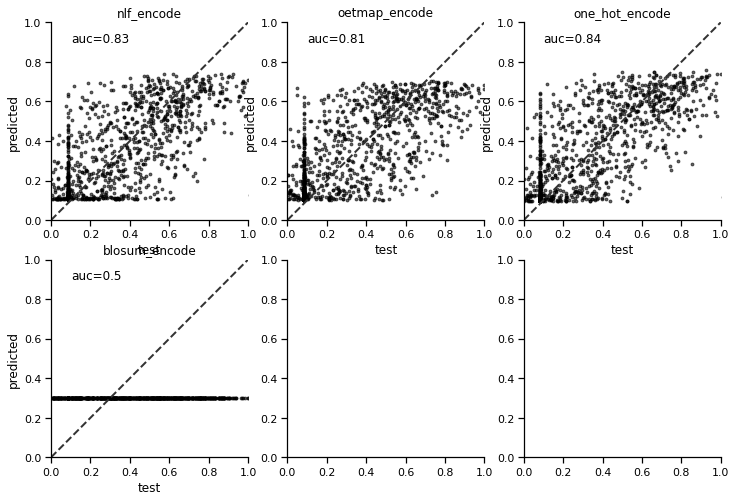

In [11]:
def auc_score(true,sc,cutoff=.426):
    
    #if cutoff!=None:
    true = (true<=cutoff).astype(int)
    sc = (sc<=cutoff).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(true, sc, pos_label=1)
    r = metrics.auc(fpr, tpr)
    #print (r)
    return  r

def test_predictor(allele, encoder, ax=None):
    
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    reg = MLPRegressor(hidden_layer_sizes=(1,), alpha=0.0005, max_iter=1500,
                        activation='logistic', solver='lbfgs', random_state=2)
    df = ep.get_training_set(allele, length=9)
    print (len(df))
    X = df.peptide.apply(lambda x: pd.Series(encoder(x)),1)
    y = df.log50k
    
    res=[]
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        #pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', reg)])
        reg.fit(X_train, y_train)    
        sc = reg.predict(X_test)
        auc = ep.auc_score(y_test,sc,cutoff=.426)
        res.append(auc)
    auc = np.mean(res)
    
    if ax != None:
        x=pd.DataFrame(np.column_stack([y_test,sc]),columns=['test','predicted'])
        x.plot('test','predicted',kind='scatter',s=8,c='black',alpha=0.6,ax=ax)
        ax.plot((0,1), (0,1), ls="--", lw=2, c=".2")
        ax.set_xlim((0,1));  ax.set_ylim((0,1))
        ax.set_title(encoder.__name__)
        ax.text(.1,.9,'auc=%s' %round(auc,2))
        sns.despine()
    return auc

sns.set_context('notebook')
encs=[nlf_encode,oetmap_encode,one_hot_encode,blosum_encode,random_encode]
allele='HLA-A*03:01'
fig,axs=plt.subplots(2,3,figsize=(12,8))
axs=axs.flat
i=0
for enc in encs:
    print (enc)
    test_predictor(allele,enc,ax=axs[i])
    i+=1
    
plt.tight_layout()
fig.savefig('basicmhc1_encoders.jpg',dpi=100)

In [ ]:
m1_alleles = ep.get_preset_alleles('mhc1_supertypes')
res={}
for a in m1_alleles:
    res[a] = []
    for enc in encs:
        print (a,enc)
        auc=test_predictor(a,enc)
        res[a].append(auc)       

In [ ]:
encdf = pd.DataFrame(res, index=['nlf','one hot','blosum','random'])
encdf['mean'] = encdf.mean(1)
encdf.round(3)

## Build a predictor

It can be seen from the plots that blosum_encoding gives superior results (highest auc value) for this particular test/train set and allele. Repeating the process generally shows the same outcome. Now that we know how to encode the peptides and make a model we can do it for any allele. We can write a routine that build the predictor from any training set.

In [ ]:
def build_predictor(allele, encoder=None, length=9):
    """Build a regression model using peptide encoder and test data"""

    from sklearn.neural_network import MLPRegressor
    #get allele specific predictor
    if encoder==None:
        encoder=nlf_encode
    data = ep.get_training_set(allele, length=length)
    
    if len(data)<100:
        return
    reg = MLPRegressor(hidden_layer_sizes=(1,), alpha=0.0005, max_iter=1500,
                        activation='logistic', solver='lbfgs', random_state=2)
    X = data.peptide.apply(lambda x: pd.Series(encoder(x)),1)
    y = data.log50k
    y.hist()
    print (allele, len(X))
    reg.fit(X,y)
    return reg

## Train and save models

Now we can just use the code above for all alleles in which we have training data (>200 samples) and produce a model for each one. Each model is saved to disk for later use so we don't have to re-train every time we want to predict peptides for that allele. sklearn uses the joblib library to persist models, which is similar to the pickle module.

In [13]:
import joblib

def get_allele_names():
    d = ep.get_training_set(length=9)
    a = d.allele.value_counts()
    a =a[a>100]
    return list(a.index)

def train_models():
    alleles=['HLA-A*02:01','HLA-A*02:02']
    path = 'models'
    os.makedirs(path,exist_ok=True)
    for a in alleles:
        fname = os.path.join(path, a+'.joblib')
        reg = build_predictor(a, blosum_encode, 9)
        if reg is not None:
            joblib.dump(reg, fname, protocol=2)
        

In [ ]:
allele='HLA-A*02:06'
encoder = one_hot_encode
#reg = joblib.load('models/HLA-A*02:01.joblib')
reg = build_predictor(allele, encoder, 9)
reg

data = mhclearn.get_evaluation_set2(allele, length=9)#[:310]
s = data.peptide
y = data.log50k
y.hist()
#print (data)
X = s.apply(lambda x: pd.Series(encoder(x)),1)
sc = reg.predict(X).round(4)
auc = ep.auc_score(y,sc,cutoff=.426)
print (auc)

x=pd.DataFrame(np.column_stack([y,sc]),columns=['test','predicted'])
fig,ax=plt.subplots(1,1,figsize=(6,6))
x.plot('test','predicted',kind='scatter',s=20,ax=ax)
ax.plot((0,1), (0,1), ls="--", lw=2, c=".2")
ax.set_xlim((0,1));  ax.set_ylim((0,1))

## Comparison to other prediction algorithms

The two best MHC-class I prediction tools are currently netMHC/netMHCpan-4.0 and MHCFlurry. It is useful to compare our results to those. In order to do this I have implemented the algorithm we made (which uses the code above) as a predictor in the `epitopepredict` package. The object is created using `P = ep.get_predictor('basicmhc1')`. This standardizes the calls to prediction and the results returned so it can be directly compared to the other tools. The code below creates 3 predictor objects and evaluates their performance on some new data for each allele available. The score is then recoreded each time. Importantly, the peptides in the evaluation set are not present in the training set.

Note that predictors all return an ic50 value but internally use the log50k value for fitting. The predictors are evaluated using the roc auc metric with a threshold of 500nM. The auc is a common metric for classiifcation and can be used for regression if a threshold is chosen. Though others measures may be used such as pearson correlation co-efficient.

In [ ]:
def evaluate_predictor(P, allele):

    data = mhclearn.get_evaluation_set1(allele, length=9)
    print (len(data))
    if len(data) < 200:
        return None,None,None
    P.predict_peptides(list(data.peptide), alleles=allele, cpus=14)
    x = P.get_scores(allele)
    #x = P.data
    x = data.merge(x,on='peptide') 
    #print (x[:4])
    #x.plot(x='ic50',y='score',kind='scatter',s=20,)
    #auc = auc_score(x.log50k_x,x.log50k_y,cutoff=.426)
    auc = round(auc_score(x.ic50,x.score,cutoff=500),3)
    import scipy
    pr = scipy.stats.pearsonr(x.ic50, x.score)[0]
    return auc, pr, data

reload(base)
reload(mhclearn)

def run_tests():
    preds = [base.get_predictor('basicmhc1'),
             base.get_predictor('netmhcpan',scoring='affinity'),
             ep.get_predictor('mhcflurry')]
    comp=[]
    test_alleles = mhclearn.get_allele_names()#[:20]
    print (len(test_alleles))
    for P in preds:
        m=[]
        for a in test_alleles:
            print (a)
            if not a.startswith('HLA'): continue
            try:
                auc,pr,df = evaluate_predictor(P, a)
                if auc==None:
                    continue
                m.append((a,auc,pr,len(df)))            
            except Exception as e:
                print (a,e)
                pass
            print (P, auc, pr)
        m=pd.DataFrame(m,columns=['allele','auc','pearson r','size'])
        m['name'] = P.name
        comp.append(m)
    return comp

comp = run_tests()      

## Results

Finally we use the resultant dataframe to plot the auc scores for each method per allele. 

In [ ]:
c=pd.concat(comp)
c.to_csv('benchmarks.csv')
print (len(c))

40


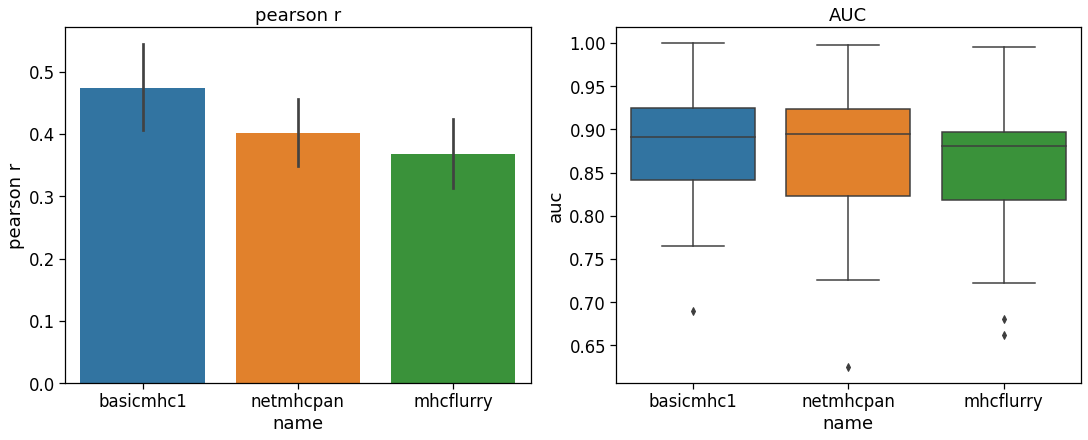

In [27]:
c = pd.read_csv('benchmarks.csv')
a=pd.pivot_table(c,index=['allele','size'],columns='name',values='auc')
r=pd.pivot_table(c,index=['allele','size'],columns='name',values='pearson r')
print (len(a))
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

fig = plt.figure(constrained_layout=True,figsize=(15,6),facecolor='white')
gs = fig.add_gridspec(1, 2, hspace=1)
ax = fig.add_subplot(gs[0])
#x.plot(x='basicmhc1',y='netmhcpan',kind='scatter',s=50,c='orange',ax=ax)
#x.plot(x='basicmhc1',y='mhcflurry',kind='scatter',s=50,c='green',ax=ax)
#ax.plot((0,1), (0,1), ls="--", lw=2, c=".2")
#ax.set_xlim(.76,.94);ax.set_ylim(.76,.94)
sns.barplot(data=c,y='pearson r',x='name',ax=ax)
ax.set_title('pearson r')

ax = fig.add_subplot(gs[1])
sns.boxplot(data=c,y='auc',x='name',ax=ax)
#ax = fig.add_subplot(gs[2:])
#g=sns.barplot(data=c,y='score',x='allele',hue='name', ax=ax)
#plt.legend(bbox_to_anchor=(1.1, 1.05),fontsize=16)
#plt.setp(ax.get_xticklabels(), rotation=90)
#plt.tight_layout()
ax.set_title('AUC')
plt.savefig('basicmhc1_benchmarks.png',dpi=300)


You can see our method is close to the other two for this evaluation set. Though our model is limited in several ways:

* it only works with alleles it has been trained with - it's not pan specific
* some alleles have preference for different peptide lengths and this is not accounted for
* information on the mhc sequence is not used

One hot encoding appears just as good as using blosum63 encoding. It is not clear why. As mentioned the predictor is available from within the epitopepredict package. It is used as a basic simple model only. To create the basic MHC predictor in epitopepredict we would use the code below. In the future this approach will be used as a basis for improving the predictor. Improvements would include handling different length peptides and changing the regression model.

## Using epitopepredict

In [ ]:
P = ep.get_predictor('basicmhc1')
from epitopepredict import peptutils
seqs = peptutils.create_random_sequences(10)
df = pd.DataFrame(seqs,columns=['peptide'])
res = P.predict_peptides(df.peptide, alleles=ep.get_preset_alleles('mhc1_supertypes'), cpus=1)

## References

* Gök M, Özcerit AT. OETMAP: A new feature encoding scheme for MHC class i binding prediction. Mol Cell Biochem. 2012; doi: 10.1007/s11010-011-1000-5.
* L. Nanni and A. Lumini, “A new encoding technique for peptide classification,” Expert Syst. Appl., vol. 38, no. 4, pp. 3185–3191, 2011.
* V. Jurtz, S. Paul, M. Andreatta, P. Marcatili, B. Peters, and M. Nielsen, “NetMHCpan-4.0: Improved Peptide–MHC Class I Interaction Predictions Integrating Eluted Ligand and Peptide Binding Affinity Data,” J. Immunol., vol. 199, no. 9, 2017.
* T. J. O’Donnell, A. Rubinsteyn, M. Bonsack, A. B. Riemer, U. Laserson, and J. Hammerbacher, “MHCflurry: Open-Source Class I MHC Binding Affinity Prediction,” Cell Syst., vol. 7, no. 1, p. 129–132.e4, 2018.
* J. Hu and Z. Liu, “DeepMHC : Deep Convolutional Neural Networks for High-performance peptide-MHC Binding Affinity Prediction,” bioRxiv, pp. 1–20, 2017.
* https://www.iedb.org/